In [1]:
import math
import torch

import numpy as np
import gpytorch
from gpytorch.kernels import RBFKernel
from ntwrk.bayesopt import BayesOpt
import matplotlib.pyplot as plt

In [2]:
def true_func(x, noise=0.02):
    return -torch.sin(3 * (x-1.)) - (x - 1.).pow(2) + 0.7 * (x-1.) + noise * torch.randn(x.shape)

In [3]:
x = torch.linspace(0, 3)
y = true_func(x, noise=0)

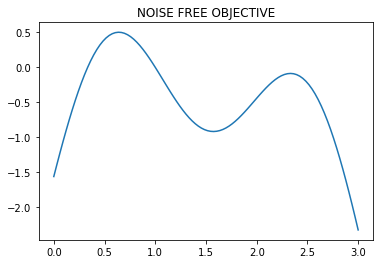

In [4]:
plt.plot(x, y)
plt.title("NOISE FREE OBJECTIVE")
plt.show()

In [5]:
def expected_improvement(bayesopt, test_points, explore=0.01):
    bayesopt.surrogate.train()
    mu_sample = bayesopt.surrogate(bayesopt.train_x).mean
    current_max, max_ind = mu_sample.max(0)

    bayesopt.surrogate.eval()
    bayesopt.surrogate_lh.eval()
    pred_dist = bayesopt.surrogate_lh(bayesopt.surrogate(test_points))
    mu_test = pred_dist.mean
    var_test = pred_dist.variance
    
    
    imp = mu_test - current_max - explore
    z = imp.div(var_test)
    std_normal = torch.distributions.Normal(torch.tensor([0.0]), torch.tensor([1.0]))

    ei = imp * std_normal.cdf(z) + var_test * std_normal.log_prob(z).exp()
    ei[var_test == 0.] = 0.
    
    return ei

In [6]:
max_x = 3.

rate = torch.rand(1) * max_x
rwrd = true_func(rate)


bo = BayesOpt(rate, rwrd, max_x=max_x)


In [7]:
rate

tensor([0.5240])

In [8]:
bo.surrogate_lh.eval();
bo.surrogate.eval();

test_points = torch.linspace(0, 3., 200).float()
test_dist = bo.surrogate_lh(bo.surrogate(test_points))

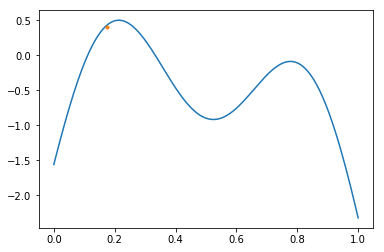

In [9]:
plt.plot(test_points.div(max_x), true_func(test_points, 0.).detach())
plt.plot(bo.train_x, bo.train_y, marker='.', linestyle="None")
plt.show()

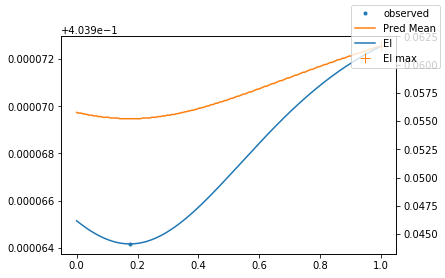

before update: 
torch.Size([1, 1])
after update: 
torch.Size([2, 1])


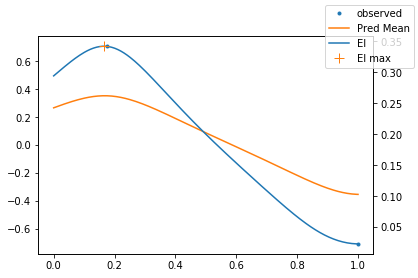

before update: 
torch.Size([2, 1])
after update: 
torch.Size([3, 1])


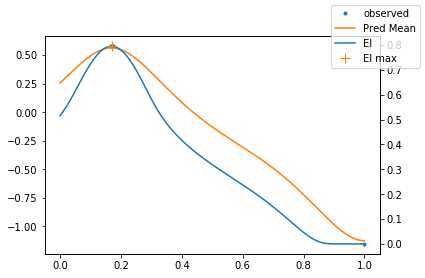

before update: 
torch.Size([3, 1])
after update: 
torch.Size([4, 1])


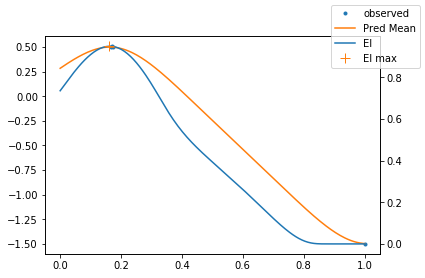

before update: 
torch.Size([4, 1])
after update: 
torch.Size([5, 1])


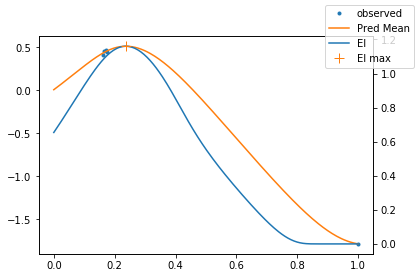

before update: 
torch.Size([5, 1])
after update: 
torch.Size([6, 1])


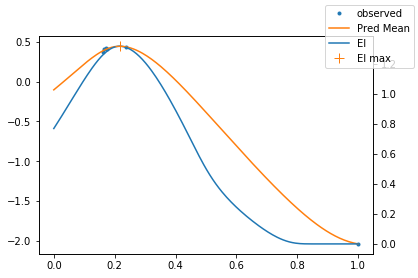

before update: 
torch.Size([6, 1])
after update: 
torch.Size([7, 1])


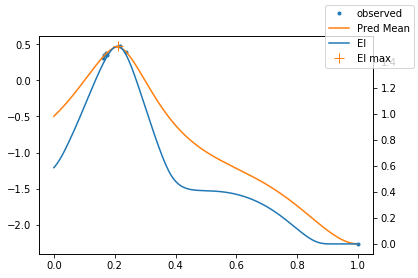

before update: 
torch.Size([7, 1])
after update: 
torch.Size([8, 1])


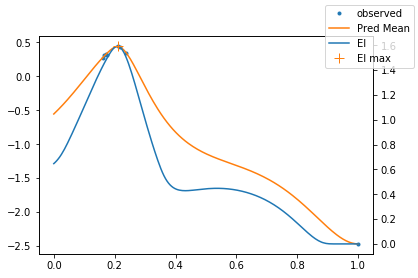

before update: 
torch.Size([8, 1])
after update: 
torch.Size([9, 1])


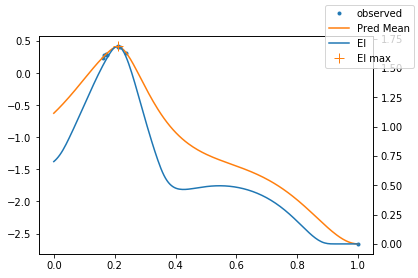

before update: 
torch.Size([9, 1])
after update: 
torch.Size([10, 1])


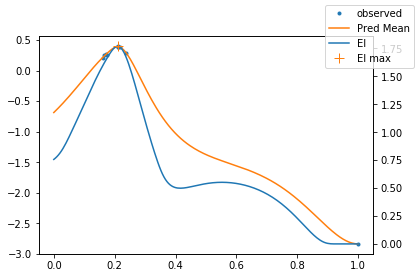

before update: 
torch.Size([10, 1])
after update: 
torch.Size([11, 1])


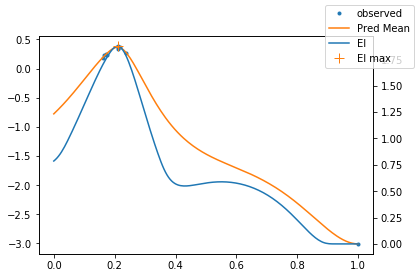

before update: 
torch.Size([11, 1])
after update: 
torch.Size([12, 1])


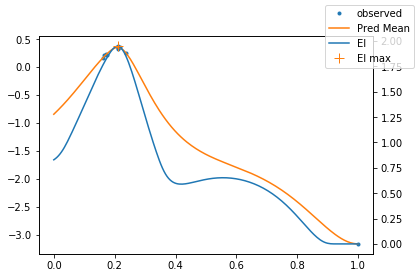

before update: 
torch.Size([12, 1])
after update: 
torch.Size([13, 1])


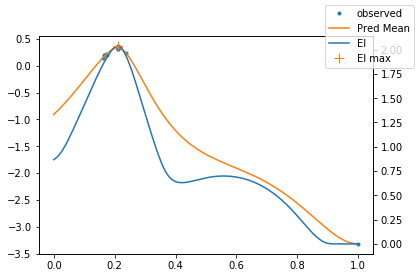

before update: 
torch.Size([13, 1])
after update: 
torch.Size([14, 1])


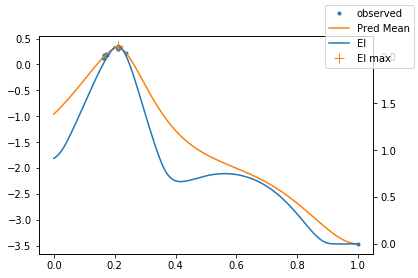

before update: 
torch.Size([14, 1])
after update: 
torch.Size([15, 1])


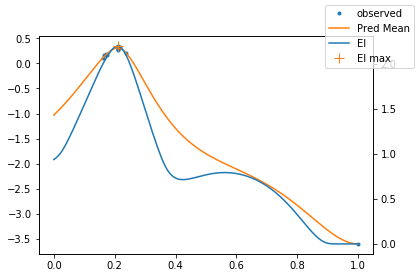

before update: 
torch.Size([15, 1])
after update: 
torch.Size([16, 1])


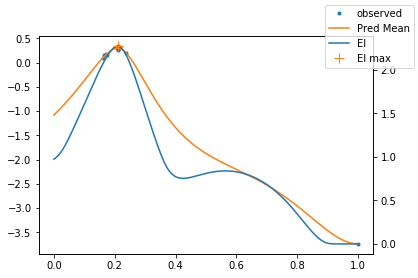

before update: 
torch.Size([16, 1])
after update: 
torch.Size([17, 1])


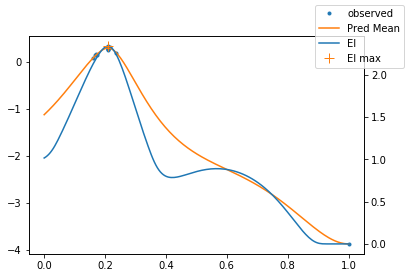

before update: 
torch.Size([17, 1])
after update: 
torch.Size([18, 1])


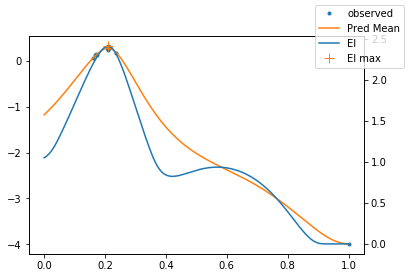

before update: 
torch.Size([18, 1])
after update: 
torch.Size([19, 1])


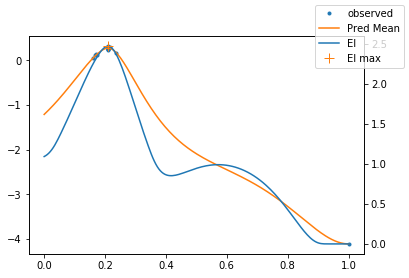

before update: 
torch.Size([19, 1])
after update: 
torch.Size([20, 1])


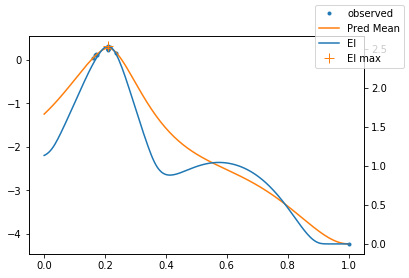

before update: 
torch.Size([20, 1])
after update: 
torch.Size([21, 1])


In [10]:
rnds = 20

for i in range(rnds):
    bo.train_surrogate(iters=200, overwrite=False)

    EI = expected_improvement(bo, test_points.div(max_x), explore=0.05)
    pred_mean = bo.surrogate_lh(bo.surrogate(test_points.div(max_x))).mean

    best_ac, ac_ind = EI.max(0)
    next_test = test_points[ac_ind]


    fig, ax1 = plt.subplots()
    ax1.plot(bo.train_x, bo.train_y.detach(),
             marker='.', linestyle="None", label="observed")
    ax1.plot(test_points.div(max_x), pred_mean.detach(), label="Pred Mean")
    ax2 = ax1.twinx()
    ax2.plot(test_points.div(max_x), EI.detach(),
             label="EI")
    ax2.plot(next_test.div(max_x), best_ac.detach(),
             label="EI max", marker="+", linestyle="None", markersize=10)
    fig.legend()
    plt.show()

    rwrd = true_func(next_test)
    bo.update_obs(next_test.unsqueeze(-1), rwrd.unsqueeze(-1))
    
#     print(bo.train_x, bo.train_y)

## Now Lets Try it With a Network

In [18]:
import sys
sys.path.append("../ntwrk/gym/")
import network_sim
import gym

In [19]:
env = gym.make("PccNs-v0")
env.reset()

History length: 10
Features: ['sent latency inflation', 'latency ratio', 'send ratio']
Getting min obs for ['sent latency inflation', 'latency ratio', 'send ratio']
Reward: 0.00, Ewma Reward: 0.00


/home/vagrant/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


array([0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1.,
       1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1.])

In [25]:
max_x = 1000.

rate = torch.rand(1) * max_x
rwrd = torch.tensor(env.step(rate)[1]).unsqueeze(-1)

In [26]:
bo = BayesOpt(rate, rwrd, max_x=max_x)
print(bo.train_x, bo.train_y)

tensor([0.2899]) tensor([-2.1920])


In [27]:
bo.surrogate_lh.eval();
bo.surrogate.eval();

test_points = torch.linspace(0, max_x, 200).float()
test_dist = bo.surrogate_lh(bo.surrogate(test_points))

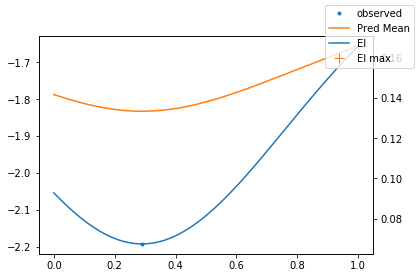

before update: 
torch.Size([1, 1])
after update: 
torch.Size([2, 1])
tensor([0.2899, 1.0000]) tensor([ 0.7071, -0.7071])


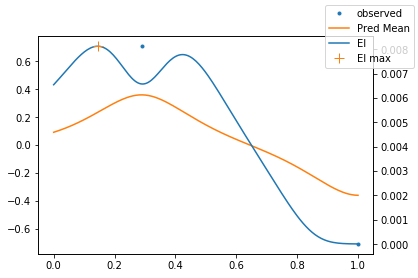

before update: 
torch.Size([2, 1])
after update: 
torch.Size([3, 1])
tensor([0.2899, 1.0000, 0.1457]) tensor([ 0.2879, -1.1124,  0.8245])


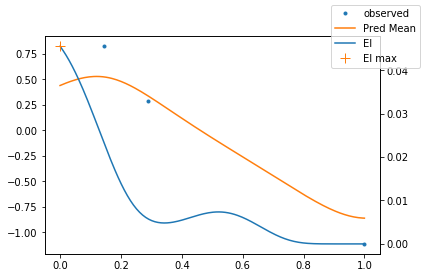

before update: 
torch.Size([3, 1])
after update: 
torch.Size([3, 1])
tensor([1.0000, 0.1457, 0.0000]) tensor([-0.4506,  1.1460, -0.6954])


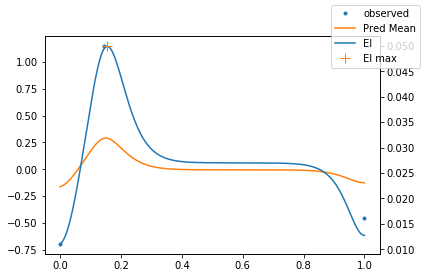

before update: 
torch.Size([3, 1])
after update: 
torch.Size([3, 1])
tensor([0.1457, 0.0000, 0.1558]) tensor([-0.1639, -0.9079,  1.0718])


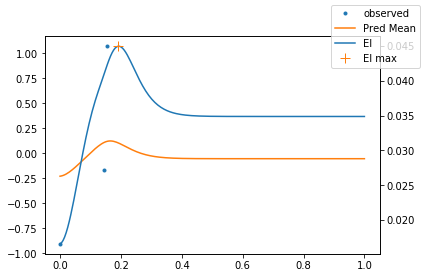

before update: 
torch.Size([3, 1])
after update: 
torch.Size([3, 1])
tensor([0.0000, 0.1558, 0.1910]) tensor([-1.0163,  0.0334,  0.9829])


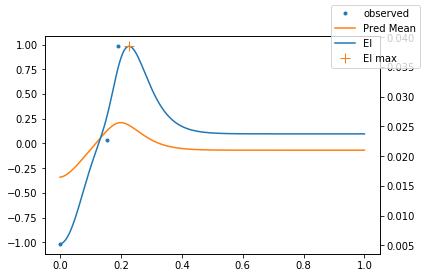

before update: 
torch.Size([3, 1])
after update: 
torch.Size([3, 1])
tensor([0.1558, 0.1910, 0.2261]) tensor([-1.1533,  0.6258,  0.5275])


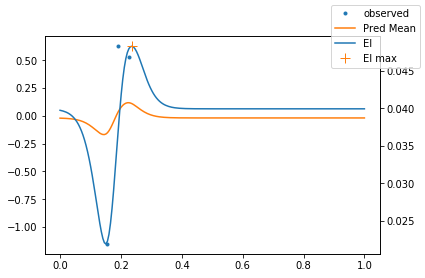

before update: 
torch.Size([3, 1])
after update: 
torch.Size([3, 1])
tensor([0.1910, 0.2261, 0.2362]) tensor([ 0.6780,  0.4704, -1.1485])


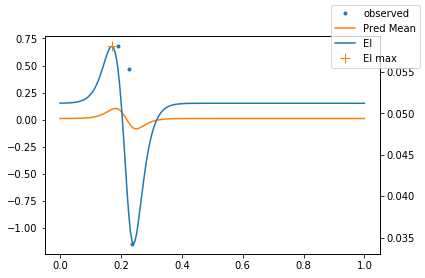

before update: 
torch.Size([3, 1])
after update: 
torch.Size([3, 1])
tensor([0.2261, 0.2362, 0.1709]) tensor([ 0.8839,  0.2015, -1.0854])


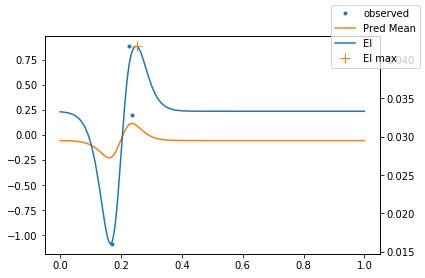

before update: 
torch.Size([3, 1])
after update: 
torch.Size([3, 1])
tensor([0.2362, 0.1709, 0.2513]) tensor([ 1.1485, -0.4709, -0.6776])


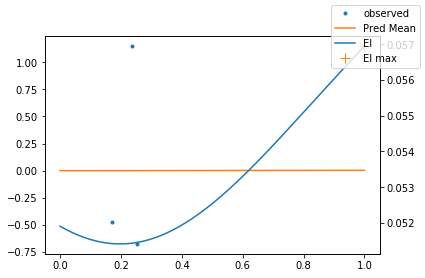

before update: 
torch.Size([3, 1])
after update: 
torch.Size([3, 1])
tensor([0.1709, 0.2513, 1.0000]) tensor([-0.2187, -0.8725,  1.0913])


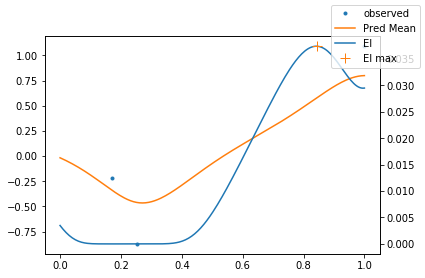

before update: 
torch.Size([3, 1])
after update: 
torch.Size([3, 1])
tensor([0.2513, 1.0000, 0.8442]) tensor([-0.3982,  1.1378, -0.7396])


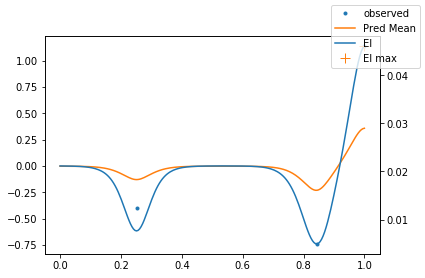

before update: 
torch.Size([3, 1])
after update: 
torch.Size([3, 1])
tensor([1.0000, 0.8442, 1.0000]) tensor([ 0.9038,  0.1705, -1.0743])


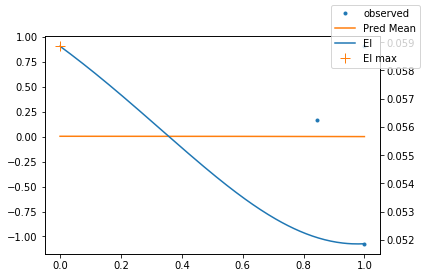

before update: 
torch.Size([3, 1])
after update: 
torch.Size([3, 1])
tensor([0.8442, 1.0000, 0.0000]) tensor([ 1.1536, -0.6195, -0.5341])


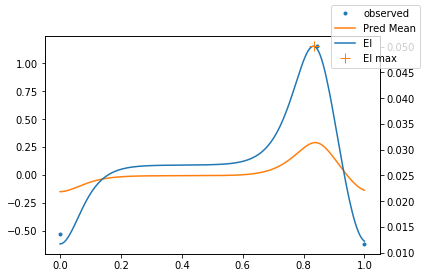

before update: 
torch.Size([3, 1])
after update: 
torch.Size([3, 1])
tensor([1.0000, 0.0000, 0.8342]) tensor([-0.5253,  1.1532, -0.6278])


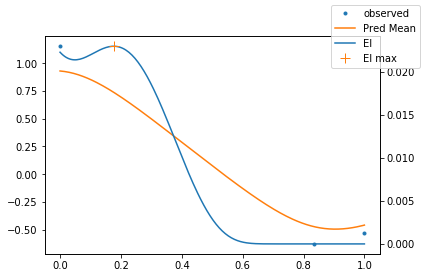

before update: 
torch.Size([3, 1])
after update: 
torch.Size([3, 1])
tensor([0.0000, 0.8342, 0.1759]) tensor([-0.5630, -0.5916,  1.1546])


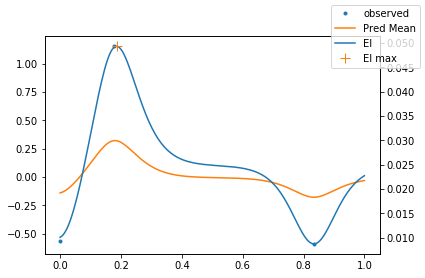

before update: 
torch.Size([3, 1])
after update: 
torch.Size([3, 1])
tensor([0.8342, 0.1759, 0.1859]) tensor([-0.6092,  1.1541, -0.5449])


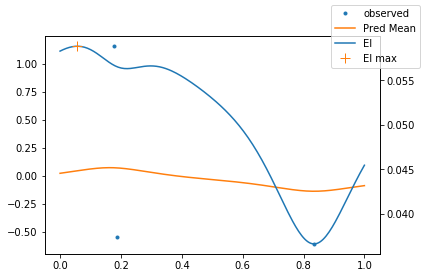

before update: 
torch.Size([3, 1])
after update: 
torch.Size([3, 1])
tensor([0.1759, 0.1859, 0.0553]) tensor([ 1.1293, -0.7732, -0.3562])


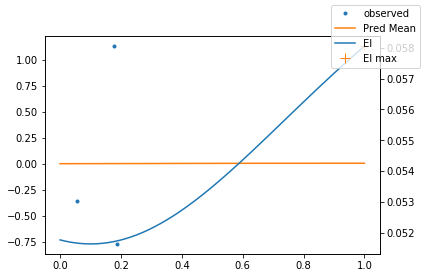

before update: 
torch.Size([3, 1])
after update: 
torch.Size([3, 1])
tensor([0.1859, 0.0553, 1.0000]) tensor([-0.9835, -0.0322,  1.0157])


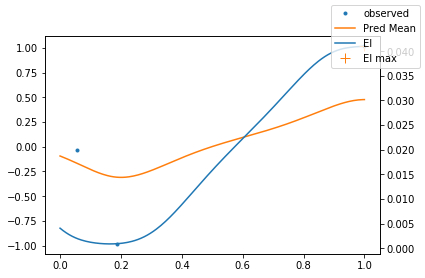

before update: 
torch.Size([3, 1])
after update: 
torch.Size([3, 1])
tensor([0.0553, 1.0000, 1.0000]) tensor([-0.8658, -0.2288,  1.0946])


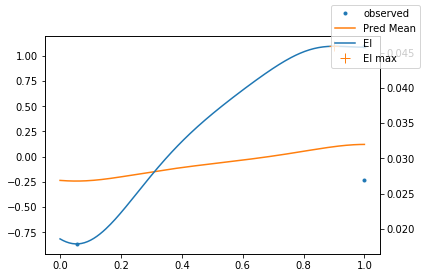

before update: 
torch.Size([3, 1])
after update: 
torch.Size([3, 1])
tensor([1.0000, 1.0000, 0.8995]) tensor([-0.0088,  1.0044, -0.9956])


In [28]:
rnds = 20
max_obs = 3
for i in range(rnds):
    bo.train_surrogate(iters=200, overwrite=True)

    EI = expected_improvement(bo, test_points.div(max_x), explore=1.)
    pred_mean = bo.surrogate_lh(bo.surrogate(test_points.div(max_x))).mean

    best_ac, ac_ind = EI.max(0)
    next_test = test_points[ac_ind]


    fig, ax1 = plt.subplots()
    ax1.plot(bo.train_x, bo.train_y.detach(),
             marker='.', linestyle="None", label="observed")
    ax1.plot(test_points.div(max_x), pred_mean.detach(), label="Pred Mean")
    ax2 = ax1.twinx()
    ax2.plot(test_points.div(max_x), EI.detach(),
             label="EI")
    ax2.plot(next_test.div(max_x), best_ac.detach(),
             label="EI max", marker="+", linestyle="None", markersize=10)
    fig.legend()
    plt.show()

    rwrd = torch.tensor(env.step(next_test.unsqueeze(0))[1])
    bo.update_obs(next_test.unsqueeze(-1), rwrd.unsqueeze(-1), max_obs=max_obs)
    
#     if bo.train_x.numel() > max_obs:
# #         bo.update_obs(bo.train_x[-max_obs:], bo.train_y[-max_obs:])
#         bo.train_x = bo.train_x[-max_obs:]
#         bo.train_y = bo.train_y[-max_obs:]
#         bo.surrogate.set_train_data(bo.train_x, bo.train_y, strict=False)
    
    print(bo.train_x, bo.train_y)

In [17]:
next_test

tensor(201.0050)